# Здесь построим программу для вывода пасспортов скважин
Используем гугл хранилище, файл должен быть открыть в Google Colaboratory (требуется соединение с интернетом). Пасспорта скважин оформляются в соответсвии с данными в сводных ведомостях в установленном формате.

Важное в оформлении сводных ведомостей: 
1.   Дата съемки должна быть обозначена ДАТОЙ
2.   Измерения фиксируется при дате съемки темпераратур (второе измерение), если хочется убрать это строчку, то просто удаляем дату второго измерения
3.   

Монтируем Гугл диск (важно зайти с аккаунта на котором хранятся файлы). Запускаем следующий раздел (кнопка play).

Пояснения: 
1. Можно использовать локальное хранилище если указать новые пути для используемых томов. Для этого раскрываем скрытые ячейки и меняем переменную path_to_file (которая соответствует путям файлов, не петаем слеши /\)
2. В новом сезоне необходимо добавлять соответствующие листы сводных ведомостей в list_of_table_names (список экселевских листов в файле)





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Импорт библиотек и функций 
(запускаем скрытый код ниже) спрятано чтобы не было страшно

In [37]:
import pandas as pd
import numpy as np
import os

import openpyxl
from openpyxl.cell import WriteOnlyCell
from openpyxl.comments import Comment
from openpyxl.styles import PatternFill, Border, Side, Alignment, Protection, Font

from openpyxl.chart import (
  ScatterChart,
  Reference,
  Series,
  LineChart,
)
from openpyxl.chart.axis import DateAxis
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, RegularTextRun
from openpyxl.drawing.image import Image

import matplotlib.pyplot as plt

from PIL import Image as PIL_Image
# import Image as PIL_Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



In [151]:
def read_df(path_to_file, name_of_area, list_of_table_names,  column_with_well_names = 'Unnamed: 3'):
  # например: column_with_well_names = 'Unnamed: 3' # значит третью колонку мы используем для обозначения названий скважин

  for i, sheet in enumerate (list_of_table_names):
    if i==0:
        df = pd.read_excel(path_to_file, sheet_name = sheet, skiprows = 12) # вроде вставка дат работает как надо
        rename_df(df, column_with_well_names, name_of_area)
    else:
        df_temp = pd.read_excel(path_to_file, sheet_name = sheet, skiprows = 12) # вроде вставка дат работает как надо
        rename_df(df_temp, column_with_well_names, name_of_area)
        df = pd.concat([df, df_temp])
    df = df[df['Дата'].notna()]
    df = df[df['Скважина'].notna()]
    df['Скважина'] = df['Скважина'].astype(str).str.replace(',', '.')
  return(df)

def rename_df(df, column_with_well_names, name_of_area = 'Default'):
  # переименовываем и удаляем ненужные колонки, column_with_well_names здесь означает колонку с названием скважины

  # additional_columns = True
  # if name_of_area == 'Газопоршневая электростанция':
  #   additional_columns = False



  df.rename(columns = {'Unnamed: 1' : 'Позиция по ГП', column_with_well_names : 'Скважина', 'Дата.1' : 'ДАТА', 'Unnamed: 13' : 'Высота ТС от уровня земли, м', 
                        'Unnamed: 9' : '№ Термокосы', 'Unnamed: 20' : 'Температура воздуха, °С',
                        0:str('0.0'), 0.5:str('0.5'), 1:str('1.0'), 1.5:str('1.5'), 2:str('2.0'), 2.5:str('2.5'), 3 : str('3.0'), 
                        4:str('4.0'), 5:str('5.0'), 6:str('6.0'), 7:str('7.0'), 8:str('8.0'), 9:str('9.0'), 
                        10:str('10.0'), 12:str('12.0'), 14:str('14.0'), 15:str('15.0')}, inplace = True)
  df.rename(columns = {df.columns[-1] :'Средняя температура'}, inplace = True) # добавляем значения средних температур из сводной ведомости
  # df = df[df['Средняя температура'] != '#DIV/0!']
  # df['Средняя температура'] = (df['Средняя температура'].astype(float)//0.01)/100
  actual_columns = ['Позиция по ГП', 'Скважина', 'ДАТА', 'Высота ТС от уровня земли, м', '0.0', '№ Термокосы', 'Температура воздуха, °С', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', 
                    '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', 
                    '10.0', '12.0', '14.0', '15.0', 'Средняя температура']
  
  current_col = list(df.columns)
  for temp in current_col:
    dropped_col = []
    if temp not in actual_columns:
      dropped_col.append(temp)
    df.drop(columns = dropped_col, inplace = True)
  df.rename(columns = {'ДАТА' : 'Дата'}, inplace = True) # хз зачем я так сделал
  # добавляем костыль
  for column in actual_columns:
    if column not in df.columns:
      df[column] = float('nan')
      
def get_formatting_cells(formating_cells_col, formating_cells_row):
  # получаем диапазон форматируемых ячеек
  formating_cells = []
  formating_cells_row.append(formating_cells_row[-1])# правка
  for ind2 in formating_cells_col:
    for ind3 in formating_cells_row:
      formating_cells.append(ind2 + str(ind3))
  return (formating_cells)

def standart_formating_cell(formating_cell):
  # формат ячеек по умолчанию
  formating_cell.alignment= Alignment(horizontal='center', vertical='center', text_rotation=0,
                                      wrap_text=True, shrink_to_fit=False, indent=0)
  formating_cell.font = Font(name='Arial', size=11, bold=False, italic=False,
                             vertAlign=None, underline='none', strike=False, color='FF000000')
    
def plot_graph(df_of_well, name_of_picture_file, list_of_plottiong_columns):
    # строим график
    df_plotting = df_of_well[list_of_plottiong_columns]

    # df_plotting['Дата'] = df_plotting['Дата'].dt.strftime("%d.%m.%Y") # временно, снять выделение
    df_plotting['Дата'] = pd.to_datetime(df_plotting['Дата']).dt.strftime("%d.%m.%Y") # второй вариант, позже посмотреть на работу с остальными приложениями
    
    # размеры шрифтов
    size_of_label_text = 11
    size_of_axis_text = size_of_label_text - 2
    size_of_legend_text=size_of_label_text - 2
    
    fig, ax = plt.subplots(figsize=(11, 3))

    names = df_plotting.columns[1:].astype(float)
    for index, row in df_plotting.iterrows():

        ax.scatter(row[1:], names, s=20)
        ax.plot(row[1:], names, label=row[0])

#     names = list(df_plotting.columns[6:])
    
    ax.legend(loc="lower center", ncol=len(df_plotting), bbox_to_anchor=(0.5,-0.15), frameon=False, 
              fontsize = size_of_legend_text)
    temperatue_ticks = list((np.arange(min(list(df_plotting.dropna(axis = 1).min()[1:]))//1, 
                                       max(list(df_plotting.dropna(axis = 1).max()[1:])), 1))//1+1)
    depth_ticks = list(list((np.arange(0, max(names)+1, 1))))
  
    ax.set_ylabel('Глубина, м', size = size_of_label_text)
    ax.yaxis.set_ticks(depth_ticks)

#     # ax.set_title('Глубина, м')

    ax.set_xlabel('Температура грунта, °С', size = size_of_label_text, labelpad =10)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks(temperatue_ticks)
#     ax.tick_params(axis='both', which='major', labelsize=size_of_axis_text)

    ax.grid()
    plt.xlim(min(list(df_plotting.dropna(axis = 1).min()[1:]))//1, 
             max(list(df_plotting.dropna(axis = 1).max()[1:]))//1+1)
    plt.ylim(max(list(map(float, (list_of_plottiong_columns[1:])))), 0)
#     plt.show()
    fig.savefig(name_of_picture_file, dpi = 100, bbox_inches = 'tight')
    print('save_pic', well)
    plt.close() # отключаем показ графиков

def get_temperature_mean(row, name_of_area = False, variant = 2):
    # выщитываем среднюю температуру
    if variant == 1:
      my_list = list([row['3.0'], row['4.0'], row['5.0'], row['6.0'], row['7.0'], row['8.0'], row['9.0'], row['10.0']])
      my_list = [x for x in my_list if str(x) != 'nan']
      my_list = [x for x in my_list if str(x) != '-']

      if len(my_list) != 0:
          t_mean = round(sum(my_list)/len(my_list),2)
      else:
          t_mean = ''
    elif variant == 2:
      t_mean = round(row['Средняя температура'], 2)
    return(t_mean)

def scale_image(input_image_path,
                output_image_path,
                width=None,
                height=None
                ):
  # меняем размер в пикселях для картинок
  if fifteen_meter_well:
    width = width_for_15m_well
  else:
    width = width_for_10m_well
  
  original_image = PIL_Image.open(input_image_path)
  w, h = original_image.size
#     print('The original image size is {wide} wide x {height} '
#           'high'.format(wide=w, height=h))

  if width and height:
    max_size = (width, height)
  elif width:
    max_size = (width, h)
  elif height:
    max_size = (w, height)
  else:
    # No width or height specified
    raise RuntimeError('Width or height required!')
  if w > width:
      original_image.thumbnail(max_size, PIL_Image.ANTIALIAS)
  elif w < width:
    #print('хуй')
    modificator = w/width
    h2 = int(round(h/modificator, 2))
    original_image = original_image.resize((width, h2), PIL_Image.ANTIALIAS)
  original_image.save(output_image_path, optimize=True, quality=0.8)



def add_heading (well, variant = 1):
  if variant == 1:
    cell = WriteOnlyCell(ws, value="Паспорт термометрической скважины:")
    cell.font = Font(name='Arial', size=14, bold = 'True')
    cell.alignment = Alignment(horizontal = 'right')

    cell_well = WriteOnlyCell(ws, value=well)
    cell_well.font = Font(name='Arial', size=12, bold = 'True')
    cell_well.alignment = Alignment(horizontal = 'center')
    cell_well.border = Border(bottom=Side(border_style='thin', color='FF000000'),)
    cell_Border = WriteOnlyCell(ws, value='')
    cell_Border.border = Border(bottom=Side(border_style='thin', color='FF000000'),)

    ws.append(['']) #первый отступ
    ws.append([cell, *['']*12, cell_well, cell_Border])
    ws.merged_cells.ranges.append("A2:M2")
    ws.merged_cells.ranges.append("N2:O2")
    ws.append([])

def add_location(name_of_area, genplan_position, variant = 1):
  if variant ==1:
    column_of_center = 7
    
    cell = WriteOnlyCell(ws, value="Местоположение термоскважины:")
    cell.font = Font(name='Arial', size=12, bold = 'True')
    cell.alignment = Alignment(horizontal = 'right')

    cell_area = WriteOnlyCell(ws, value=name_of_area)
    cell_area.font = Font(name='Arial', size=12)
    cell_area.alignment = Alignment(horizontal = 'left')

    ws.append([cell,*['']*(column_of_center-1), cell_area]) ## центровка отступов
    ws.merged_cells.ranges.append("A4:G4")
    ws.merged_cells.ranges.append("H4:S4")

    cell = WriteOnlyCell(ws, value=genplan_position)
    cell.font = Font(name='Arial', size=12)
    cell.alignment = Alignment(horizontal = 'left')
    ws.append([*['']*column_of_center, cell]) ##
    ws.merged_cells.ranges.append("H5:S5")

    ws.append([])

def add_temperature_table(df_of_well, name_of_area, variant = 1):
  if variant == 1:
    cell = WriteOnlyCell(ws, value="Результаты измерений температуры:")
    cell.font = Font(name='Arial', size=12, bold = 'True')
    cell.alignment = Alignment(horizontal = 'center')
    ws.append([cell])

    # Вставляем заголовок таблицы температур
    ws.append(['Дата замера', '№ Термокосы', 'Высота оголовка, м', 'Температура воздуха, °С', 'Температура в скважине на глубине от поверхности земли, м, °С', 
               '', '', '', '', '', '', '', '', '', '', '', '', '', *['']*3*fifteen_meter_well, 'Температура средняя, °С'])
    ws.append(['', '', '', '', '0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', 
               '10.0', *['12.0', '14.0', '15.0']*fifteen_meter_well])
    
    for index, row in df_of_well.iterrows():
      if row['Дата'] !='-':
        date_value = row['Дата'].strftime("%d.%m.%Y")
      else:
        date_value = row['Дата']
      ws.append([date_value, str(row['№ Термокосы']).replace('.0', ''), row['Высота ТС от уровня земли, м'], row['Температура воздуха, °С'],
                 row['0.0'], row['0.5'], row['1.0'], row['1.5'], row['2.0'], row['2.5'], row['3.0'], row['4.0'], row['5.0'], row['6.0'], 
                 row['7.0'], row['8.0'], row['9.0'], row['10.0'], *[row['12.0'], row['14.0'], row['15.0']]*fifteen_meter_well, 
                 get_temperature_mean(row)])
    
    if fifteen_meter_well == True:
      ws.merged_cells.ranges.append("A7:V7")  
      ws.merged_cells.ranges.append("A8:A9")
      ws.merged_cells.ranges.append("B8:B9")
      ws.merged_cells.ranges.append("C8:C9")
      ws.merged_cells.ranges.append("D8:D9")
      ws.merged_cells.ranges.append("V8:V9")        
      ws.merged_cells.ranges.append("E8:U8")
    elif fifteen_meter_well==False:
      ws.merged_cells.ranges.append("A7:S7")
      ws.merged_cells.ranges.append("A8:A9")
      ws.merged_cells.ranges.append("B8:B9")
      ws.merged_cells.ranges.append("C8:C9")
      ws.merged_cells.ranges.append("D8:D9")
      ws.merged_cells.ranges.append("S8:S9")        
      ws.merged_cells.ranges.append("E8:R8")

    formating_cells = ['A8'] # format A8
    for formating_cell_position in formating_cells:
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(top=medium, left=medium, right=thin, bottom=thin)
      standart_formating_cell(formating_cell)

    # форматируем верхнюю шапку
    formating_cells = ['B8','C8', 'D8', 'E8','F8', 'G8', 'H8','I8', 'J8', 'K8','L8', 'M8',
                      'N8','O8', 'P8', 'Q8', 'R8', *['S8', 'T8','U8',]*fifteen_meter_well]
    for formating_cell_position in formating_cells:
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(top=medium, left=thin, right=thin, bottom=thin)
      standart_formating_cell(formating_cell)
    
    if fifteen_meter_well:
      formating_cells = ['V8']
    else:
      formating_cells = ['S8'] 
    for formating_cell_position in formating_cells:
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(top=medium, left=thin, right=medium, bottom=thin)
      standart_formating_cell(formating_cell)
      
    formating_cells = ['A9']
    for formating_cell_position in formating_cells:
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(top=thin, left=medium, right=thin, bottom=thin)

    formating_cells = ['B9','C9', 'D9', 'E9','F9', 'G9', 'H9','I9', 'J9', 'K9','L9', 'M9', 'N9','O9', 'P9', 'Q9','R9', *['S9', 'T9','U9',]*fifteen_meter_well]
    for formating_cell_position in formating_cells:
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(top=medium, left=thin, right=thin, bottom=thin)
      standart_formating_cell(formating_cell)
    
    if fifteen_meter_well:
      formating_cells = ['V9']
    else:
      formating_cells = ['S9']
    for formating_cell_position in formating_cells:
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(top=thin, left=thin, right=medium, bottom=thin)
      standart_formating_cell(formating_cell)
    # форматируем область значений таблицы
    count_of_meathures = len(df_of_well)
    formating_cells_col = ['A']
    formating_cells_row = list(range(10, 10+count_of_meathures))
    formating_cells = get_formatting_cells(formating_cells_col, formating_cells_row)
    for ind, formating_cell_position in enumerate (formating_cells):
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(left=medium, right=thin)
      standart_formating_cell(formating_cell)
      if str(formating_cells_row[-1]) in formating_cell_position:
        formating_cell = ws[formating_cell_position]
        formating_cell.border = Border(left=medium, right=thin, bottom=medium)
        standart_formating_cell(formating_cell)
    
    count_of_meathures = len(df_of_well)
    formating_cells_col = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
                            'O', 'P', 'Q', 'R' , *['S', 'T', 'U']*fifteen_meter_well]
    formating_cells_row = list(range(10, 10+count_of_meathures))
    formating_cells = get_formatting_cells(formating_cells_col, formating_cells_row)
    for ind, formating_cell_position in enumerate (formating_cells):
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(left=thin, right=thin)
      standart_formating_cell(formating_cell)
      if str(formating_cells_row[-1]) in formating_cell_position:
        formating_cell = ws[formating_cell_position]
        formating_cell.border = Border(left=thin, right=thin, bottom=medium)
        standart_formating_cell(formating_cell)
                          
    if fifteen_meter_well:
      formating_cells_col = ['V']
    else:
      formating_cells_col = ['S']
    formating_cells_row = list(range(10, 10+count_of_meathures))
    formating_cells = get_formatting_cells(formating_cells_col, formating_cells_row)
    for ind, formating_cell_position in enumerate (formating_cells):
      formating_cell = ws[formating_cell_position]
      formating_cell.border = Border(left=thin, right=medium)
      standart_formating_cell(formating_cell)
      if str(formating_cells_row[-1]) in formating_cell_position:
        formating_cell = ws[formating_cell_position]
        formating_cell.border = Border(left=thin, right=medium, bottom=medium)
        standart_formating_cell(formating_cell)
    
    # Настраиваем ширину ячеек
    ws.column_dimensions["A"].width = 11
    ws.column_dimensions["B"].width = 7
    ws.column_dimensions["C"].width = 10
    ws.column_dimensions["D"].width = 10
    formating_cells_col = ['E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
                          'O', 'P', 'Q', 'R', *['S', 'T', 'U']*fifteen_meter_well]
    for column_of_cells in formating_cells_col:
        ws.column_dimensions[column_of_cells].width = 6
    if fifteen_meter_well:
      ws.column_dimensions["V"].width = 10
    else:
      ws.column_dimensions["S"].width = 10

    
    ws.row_dimensions[8].height = 32.531
    ws.row_dimensions[9].height = 32.531
    
    formating_cells_row = list(range(10, 10 + count_of_meathures))
    for form_row in formating_cells_row:
        ws.row_dimensions[form_row].height = 16
    
    # блок вставки рисунка графика
    name_of_picture_file = path_to_file[:-5]+'.files/Graphs/'+str(well)+'.png'
    
    if (os.path.exists(name_of_picture_file) == False) or do_you_want_refrest_graph:
      list_of_plottiong_columns = ['Дата', '0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '4.0', '5.0', '6.0', 
                                    '7.0', '8.0', '9.0', '10.0', *['12.0', '14.0', '15.0']*fifteen_meter_well]
      plot_graph(df_of_well, name_of_picture_file, list_of_plottiong_columns)
    
    scale_image(input_image_path=name_of_picture_file,
                output_image_path=name_of_picture_file,
                width=width_for_15m_well,)
    
    img = Image(name_of_picture_file)
    ws.add_image(img, 'A24')

    #блок вставки схемы местоположения (растр)
    if name_of_area == 'Площадка ГТЭС':
      name_of_location_pic_file = path_to_file[:-5]+'.files/Locate/'+str(well)+'.png'
    else:
      name_of_location_pic_file = path_to_file[:-5]+'.files/Locate/'+str(well).replace('Т', '')+'.png'
    if os.path.exists(name_of_location_pic_file):
        scale_image(input_image_path=name_of_location_pic_file,
                    output_image_path=name_of_location_pic_file,
                    width=width_for_15m_well,)
        img = Image(name_of_location_pic_file)
        ws.add_image(img, 'A45')
    else:
        print('Для скважины', well, 'отсутствует картинка местоположения')

width_for_10m_well = 940
width_for_15m_well = 1050

thin = Side(border_style="thin", color="000000")
double = Side(border_style="double", color="000000")
medium = Side(border_style="medium", color="000000")

## 1. ПСП

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 8/Том VIII Приложение А,Б_ПСП.xlsx' # относительный путь до приложения
list_of_table_names = ['ПСП Весна 2018', 'ПСП Осень 2018', 'ПСП Весна 2019', 
                       'ПСП Осень 2019', 'ПСП Весна 2020', 'ПСП Осень 2020', 
                       'ПСП Весна 2021'] #обрабатываемые листы в порядке заполнения пасспорта
column_with_well_names = 'Unnamed: 3'
name_of_area = 'Площадка ПСП' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, list_of_table_names=list_of_table_names, name_of_area = name_of_area) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ### Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')

Для скважины ТТ258 отсутствует картинка местоположения
Vse


## 2.ГПЭС

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 8/Том VIII Приложение В,Г_ГПЭС.xlsx'
list_of_table_names = ['ГПЭС Весна 2020', 'ГПЭС Осень 2020', 'ГПЭС Весна 2021']
column_with_well_names = 'Unnamed: 3'
name_of_area = 'Газопоршневая электростанция' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, name_of_area, list_of_table_names) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ### Проверяем на 15-метровость скважины
    # if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
    #   fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')

Vse


## 3.ГТЭС

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 8/Том VIII Приложение Д,Е_ГТЭС.xlsx'
list_of_table_names = ['ГТЭС Весна 2018', 'ГТЭС Осень 2018', 'ГТЭС Весна 2019', 'ГТЭС Осень 2019', 'ГТЭС Осень 2020', 'ГТЭС Весна 2021'] #обрабатываемые листы в порядке заполнения пасспорта
column_with_well_names = 'Unnamed: 2'

name_of_area = 'Площадка ГТЭС' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, name_of_area, list_of_table_names, column_with_well_names = column_with_well_names) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ## Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')

Для скважины 115 отсутствует картинка местоположения
Для скважины 108 отсутствует картинка местоположения
Для скважины 116 отсутствует картинка местоположения
Для скважины ТТ5(2) отсутствует картинка местоположения
Для скважины ТТ8 отсутствует картинка местоположения
Для скважины 133 отсутствует картинка местоположения
Для скважины 132 отсутствует картинка местоположения
Для скважины 118 отсутствует картинка местоположения
Для скважины 131 отсутствует картинка местоположения
Для скважины 134 отсутствует картинка местоположения
Для скважины 167 отсутствует картинка местоположения
Для скважины 129 отсутствует картинка местоположения
Для скважины 96 отсутствует картинка местоположения
Для скважины 161 отсутствует картинка местоположения
Для скважины тт5 отсутствует картинка местоположения
Vse


## 4. ППиТБО

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 8/Том VIII Приложение Ж,З_ППиТБО.xlsx'
list_of_table_names = ['ППиТБО Осень 2019', 'ППиТБО Осень 2020', 'ППиТБО Весна 2021'] #обрабатываемые листы в порядке заполнения пасспорта
column_with_well_names = 'Unnamed: 2'

name_of_area = 'Площадка ГТЭС' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, name_of_area, list_of_table_names, column_with_well_names = column_with_well_names) # инициируем данные сводной ведомости в систему

df['Скважина']= df['Скважина'].str.split(".").str[0] # доабавляем костыли, по какой-то причине не удается переименовать дробную часть

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ## Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')

Vse


## 5. Обрабатываем напорник

### Том 10

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 10/Том X_Приложение А,Б_НН (ПК217.1 - 357.3).xlsx' # относительный путь до приложения
list_of_table_names = ['НН ПК217.1-ПК357.3 Весна 2018',
                       'НН ПК217.1-ПК357.3 Весна 2019',
                       'НН ПК217.1-ПК357.3 Осень 2019',
                       'НН ПК217.1-ПК357.3 Осень 2020', 
                       'НН ПК217.1-ПК357.3 весна 2021'] #обрабатываемые листы в порядке заполнения пасспорта

column_with_well_names = 'Unnamed: 2'

name_of_area = 'Напорный нефтепровод  ЦПС-ПСП' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, name_of_area = name_of_area, list_of_table_names = list_of_table_names, column_with_well_names = column_with_well_names) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ## Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')
# def rename_df(df):
#     # переименовываем и удаляем ненужные колонки
#     df.rename(columns = {'Unnamed: 1' : 'Позиция по ГП', 'Unnamed: 2':'Скважина', 'Дата.1' : 'ДАТА', 'Unnamed: 13' : 'Высота ТС от уровня земли, м', 
#                          'Unnamed: 9' : '№ Термокосы', 'Unnamed: 20' : 'Температура воздуха, °С',
#                      0:str('0.0'), 0.5:str('0.5'), 1:str('1.0'), 1.5:str('1.5'), 2:str('2.0'), 2.5:str('2.5'), 3 : str('3.0'), 
#                      4:str('4.0'), 5:str('5.0'), 6:str('6.0'), 7:str('7.0'), 8:str('8.0'), 9:str('9.0'), 
#                      10:str('10.0'), 12:str('12.0'), 14:str('14.0'), 15:str('15.0')}, inplace = True)
    
#     actual_columns = ['Позиция по ГП', 'Скважина', 'ДАТА', 'Высота ТС от уровня земли, м', '0.0', '№ Термокосы', 'Температура воздуха, °С', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', 
#                      '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', 
#                      '10.0', '12.0', '14.0', '15.0']
    
#     current_col = list(df.columns)
#     for temp in current_col:
#         dropped_col = []
#         if temp not in actual_columns:
#             dropped_col.append(temp)
#         df.drop(columns = dropped_col, inplace = True)
#     df.rename(columns = {'ДАТА' : 'Дата'}, inplace = True)
    


Для скважины 217.1 отсутствует картинка местоположения
Для скважины 217.2 отсутствует картинка местоположения
Для скважины 218.1 отсутствует картинка местоположения
Для скважины 218.2 отсутствует картинка местоположения
Для скважины 219.1 отсутствует картинка местоположения
Для скважины 219.2 отсутствует картинка местоположения
Для скважины 221.1 отсутствует картинка местоположения
Для скважины 221.2 отсутствует картинка местоположения
Для скважины 221.3 отсутствует картинка местоположения
Для скважины 222.2 отсутствует картинка местоположения
Для скважины 224.1 отсутствует картинка местоположения
Для скважины 224.2 отсутствует картинка местоположения
Для скважины 224.3 отсутствует картинка местоположения
Для скважины 225.1 отсутствует картинка местоположения
Для скважины 225.2 отсутствует картинка местоположения
Для скважины 226.2 отсутствует картинка местоположения
Для скважины 227.2 отсутствует картинка местоположения
Для скважины 227.3 отсутствует картинка местоположения
Для скважи

### Том 11

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 11/Том XI_Приложение А,Б_НН (ПК 511.2-728.1).xlsx' # относительный путь до приложения
list_of_table_names = ['НН ПК 511.2-728.1 Осень 2018', 'НН ПК 511.2-728.1 Весна 2019', 'НН ПК 511.2-728.1 Весна 2020',  'НН ПК 511.2-728.1 Осень 2020', 'НН ПК 511.2-728.1 Весна 2021']

column_with_well_names = 'Unnamed: 2'

name_of_area = 'Напорный нефтепровод  ЦПС-ПСП' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, name_of_area, list_of_table_names, column_with_well_names = column_with_well_names) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ## Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')

Для скважины 538.1 отсутствует картинка местоположения
Для скважины 539.1 отсутствует картинка местоположения
Для скважины 539.2 отсутствует картинка местоположения
Для скважины 541.1 отсутствует картинка местоположения
Для скважины 541.2 отсутствует картинка местоположения
Для скважины 542.1 отсутствует картинка местоположения
Для скважины 543.1 отсутствует картинка местоположения
Для скважины 544.1 отсутствует картинка местоположения
Для скважины 544.2 отсутствует картинка местоположения
Для скважины 545.1 отсутствует картинка местоположения
Для скважины 545.2 отсутствует картинка местоположения
Для скважины 546.1 отсутствует картинка местоположения
Для скважины 546.2 отсутствует картинка местоположения
Для скважины 547.1 отсутствует картинка местоположения
Для скважины 548.2 отсутствует картинка местоположения
Для скважины 549.2 отсутствует картинка местоположения
Для скважины 552.1 отсутствует картинка местоположения
Для скважины 552.2 отсутствует картинка местоположения
Для скважи

### Том 12

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 12/Том XII_Приложение А,Б_НН (ПК728.2-955.3).xlsx' # относительный путь до приложения
list_of_table_names = ['НН Осень 2018 ПК728.2-955.3', 'НН Весна 2018 ПК728.2-955.3', 'НН Осень 2019 ПК728.2-955.3', 'НН Весна 2019 ПК728.2-955.3',  
                       'НН Весна 2020 ПК728.2-955.3', 'НН Осень 2020 ПК728.2-955.3', 'НН Весна 2021 ПК728.2-955.3']

column_with_well_names = 'Unnamed: 2'

name_of_area = 'Напорный нефтепровод  ЦПС-ПСП' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, name_of_area, list_of_table_names, column_with_well_names = column_with_well_names) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ## Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')

Для скважины 754.2 отсутствует картинка местоположения
Для скважины 758.1 отсутствует картинка местоположения
Для скважины 758.2 отсутствует картинка местоположения
Для скважины 759.1 отсутствует картинка местоположения
Для скважины 759.2 отсутствует картинка местоположения
Для скважины 759.3 отсутствует картинка местоположения
Для скважины 760.1 отсутствует картинка местоположения
Для скважины 761.1 отсутствует картинка местоположения
Для скважины 761.2 отсутствует картинка местоположения
Для скважины 762.2 отсутствует картинка местоположения
Для скважины 770.1 отсутствует картинка местоположения
Для скважины 770.2 отсутствует картинка местоположения
Для скважины 771.1 отсутствует картинка местоположения
Для скважины 771.2 отсутствует картинка местоположения
Для скважины 772.1 отсутствует картинка местоположения
Для скважины 772.2 отсутствует картинка местоположения
Для скважины 772.3 отсутствует картинка местоположения
Для скважины 773.1 отсутствует картинка местоположения
Для скважи

## 6. Обрабатываем ЦПС

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: ignored

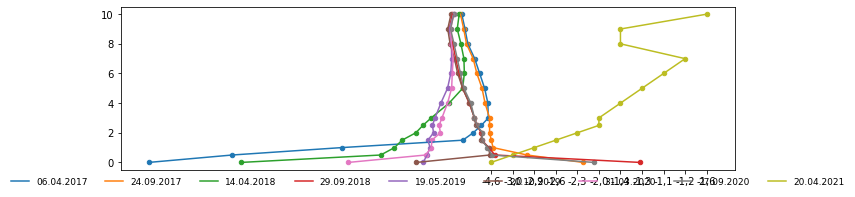

In [156]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 8/Том VIII Приложение И_ЦПС.xlsx' # относительный путь до приложения
list_of_table_names = ['ЦПС Весна 2017',
                       'ЦПС Осень 2017', 
                       'ЦПС Весна 2018',
                       'ЦПС Осень 2018', 
                       'ЦПС Весна 2019',
                       'ЦПС Осень 2019',
                       'ЦПС Весна 2020',
                       'ЦПС Осень 2020', 
                       'ЦПС Весна 2021'] #обрабатываемые листы в порядке заполнения пасспорта
column_with_well_names = 'Unnamed: 2'
name_of_area = 'Площадка ЦПС' #название площадки
do_you_want_refrest_graph = True # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, list_of_table_names=list_of_table_names, name_of_area = name_of_area, column_with_well_names = column_with_well_names) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    well = well.replace('/', '_')
    # df_of_well['Скважина'] = 
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ### Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
       
wb.save(name_of_passport_file)

print('Vse')

'ТС1_1'

In [150]:
df_of_well['Дата'].dt.strftime("%d.%m.%Y")

0    06.04.2017
0    24.09.2017
0    14.04.2018
0    29.09.2018
0    19.05.2019
0    20.10.2019
0    31.03.2020
0    27.09.2020
0    20.04.2021
Name: Дата, dtype: object

In [59]:
df[df['Скважина'] == 'ТС3.1/1']['Дата'].strftime("%d.%m.%Y")


AttributeError: ignored

In [44]:
# def read_df(path_to_file, name_of_area, list_of_table_names,  column_with_well_names = 'Unnamed: 3'):
#   # например: column_with_well_names = 'Unnamed: 3' # значит третью колонку мы используем для обозначения названий скважин

#   for i, sheet in enumerate (list_of_table_names):
#     if i==0:
#         df = pd.read_excel(path_to_file, sheet_name = sheet, skiprows = 12) # вроде вставка дат работает как надо
#         rename_df(df, column_with_well_names, name_of_area)
#     else:
#         df_temp = pd.read_excel(path_to_file, sheet_name = sheet, skiprows = 12) # вроде вставка дат работает как надо
#         rename_df(df_temp, column_with_well_names, name_of_area)
#         df = pd.concat([df, df_temp])
#     df = df[df['Дата'].notna()]
#     df = df[df['Скважина'].notna()]
#     df['Скважина'] = df['Скважина'].astype(str).str.replace(',', '.')
#   return(df)

# def rename_df(df, column_with_well_names, name_of_area = 'Default'):
#   # переименовываем и удаляем ненужные колонки, column_with_well_names здесь означает колонку с названием скважины

#   # additional_columns = True
#   # if name_of_area == 'Газопоршневая электростанция':
#   #   additional_columns = False



#   df.rename(columns = {'Unnamed: 1' : 'Позиция по ГП', column_with_well_names : 'Скважина', 'Дата.1' : 'ДАТА', 'Unnamed: 13' : 'Высота ТС от уровня земли, м', 
#                         'Unnamed: 9' : '№ Термокосы', 'Unnamed: 20' : 'Температура воздуха, °С',
#                         0:str('0.0'), 0.5:str('0.5'), 1:str('1.0'), 1.5:str('1.5'), 2:str('2.0'), 2.5:str('2.5'), 3 : str('3.0'), 
#                         4:str('4.0'), 5:str('5.0'), 6:str('6.0'), 7:str('7.0'), 8:str('8.0'), 9:str('9.0'), 
#                         10:str('10.0'), 12:str('12.0'), 14:str('14.0'), 15:str('15.0')}, inplace = True)
#   df.rename(columns = {df.columns[-1] :'Средняя температура'}, inplace = True) # добавляем значения средних температур из сводной ведомости
#   # df = df[df['Средняя температура'] != '#DIV/0!']
#   # df['Средняя температура'] = (df['Средняя температура'].astype(float)//0.01)/100
#   actual_columns = ['Позиция по ГП', 'Скважина', 'ДАТА', 'Высота ТС от уровня земли, м', '0.0', '№ Термокосы', 'Температура воздуха, °С', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', 
#                     '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', 
#                     '10.0', '12.0', '14.0', '15.0', 'Средняя температура']
  
#   current_col = list(df.columns)
#   for temp in current_col:
#     dropped_col = []
#     if temp not in actual_columns:
#       dropped_col.append(temp)
#     df.drop(columns = dropped_col, inplace = True)
#   df.rename(columns = {'ДАТА' : 'Дата'}, inplace = True) # хз зачем я так сделал
#   # добавляем костыль
#   for column in actual_columns:
#     if column not in df.columns:
#       df[column] = float('nan')

path_to_file = 'drive/MyDrive/WORK/Месояха/Том 8/Том VIII Приложение И_ЦПС.xlsx' # относительный путь до приложения
list_of_table_names = ['ЦПС Весна 2017',
                       'ЦПС Осень 2017', 
                       'ЦПС Весна 2018',
                       'ЦПС Осень 2018', 
                       'ЦПС Весна 2019',
                       'ЦПС Осень 2019',
                       'ЦПС Весна 2020',
                       'ЦПС Осень 2020', 
                       'ЦПС Весна 2021'] #обрабатываемые листы в порядке заполнения пасспорта
column_with_well_names = 'Unnamed: 2'
name_of_area = 'Площадка ЦПС' #название площадки
do_you_want_refrest_graph = False # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, list_of_table_names=list_of_table_names, name_of_area = name_of_area, column_with_well_names = column_with_well_names)

# df = pd.read_excel(path_to_file, sheet_name=list_of_table_names[0], skiprows = 12)

df

,Позиция по ГП,Скважина,Дата,№ Термокосы,"Высота ТС от уровня земли, м","Температура воздуха, °С",0.0,0.5,1.0,1.5,2.0,2.5,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,14.0,15.0,Средняя температура,ДАТА
0,1 Площадка входных сепараторов,ТС1/1,2017-04-06 00:00:00,NaN,NaN,NaN,-15.88,-12.01,-6.93,-1.31,-0.83,-0.45,-0.13,-0.15,-0.3,-0.53,-0.76,-1.08,-1.21,-1.36,NaN,NaN,NaN,-0.681667,NaN
1,1 Площадка входных сепараторов,ТС1/2,2017-04-06 00:00:00,NaN,NaN,NaN,-14.36,-9.6,-0.91,-0.42,-0.04,-0.02,0,-0.13,-0.45,-0.64,-0.87,-0.99,-1.14,-1.4,NaN,NaN,NaN,-0.719167,NaN
2,1 Площадка входных сепараторов,ТС1/3,2017-04-06 00:00:00,NaN,NaN,NaN,-14.61,-11.78,-7.31,-0.57,-0.11,0.03,-0.02,-0.02,-0.19,-0.51,-0.72,-0.97,-1.16,-1.33,NaN,NaN,NaN,-0.604167,NaN
3,1 Площадка входных сепараторов,ТС1/4,2017-04-06 00:00:00,NaN,NaN,NaN,-10.85,-6.92,-0.78,-0.09,0.05,0.05,0.05,-0.07,-0.23,-0.53,-0.7,-0.89,-1.1,-1.25,NaN,NaN,NaN,-0.596667,NaN
4,2 Площадка сброса пластовой воды с НГСВ,ТС2/1,2017-04-08 00:00:00,NaN,NaN,NaN,-16.25,-2.94,-0.34,0,-0.13,-0.15,-0.34,-0.55,-0.91,-1.16,-1.31,-1.54,-1.77,-1.9,NaN,NaN,NaN,-1.21917,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,"217,2",ТС217.2/1,2021-05-15 00:00:00,4540.0,"1,30","3,0","-1,7","-1,4","-0,4","-0,2","-0,2","-0,2","0,0","-0,3","-0,6","-0,7","-1,0","-1,1","-1,3","-1,4",NaN,NaN,NaN,"-0,8",NaN
235,219 Емкость дренажная сбора производственно-до...,ТС219/1,2021-04-21 00:00:00,4679.0,"1,00","2,0","-6,1","-6,0","-5,9","-6,8","-5,4","-3,5","-2,8","-2,4","-2,7","-2,9","-3,3","-3,6","-3,5","-3,3","-2,8","-2,7","-2,8","-3,1",NaN
236,221 Мачта прожекторная Н=28м,ТС221.1/1,2021-05-15 00:00:00,4543.0,"0,60","3,0","-1,2","-1,7","-1,9","-0,5","-1,8","0,4","-1,6","-0,4","1,3","1,0","0,2","-0,9","-1,1","-1,4",NaN,NaN,NaN,"0,0",NaN
237,221 Мачта прожекторная Н=28м,ТС221.4/1,2021-05-14 00:00:00,4465.0,"1,00","3,0","-0,3","-1,7","-2,5","-2,8","-3,2","-3,8","-3,8","-4,2","-4,3","-4,1","-4,1","-3,8","-3,5","-3,5",NaN,NaN,NaN,"-4,0",NaN


# 7. ЖК

In [ ]:
path_to_file = 'drive/MyDrive/WORK/Месояха/Том 8/Сводная_ЖК весна 2021.xlsx' # относительный путь до приложения
list_of_table_names = ['ЖК весна 2021'] #обрабатываемые листы в порядке заполнения пасспорта
column_with_well_names = 'Unnamed: 2'
name_of_area = 'Площадка ЖК' #название площадки
do_you_want_refrest_graph = True # Хотите ли обновить графики (True - если хотим, False - если нет)
df = read_df(path_to_file, list_of_table_names=list_of_table_names, name_of_area = name_of_area, column_with_well_names = column_with_well_names) # инициируем данные сводной ведомости в систему

# задаём файл паспортов и сохранаяем его рядом с обрабатываемым файлом (сводной) (здесь _passports означает приписку к первоначальному файлу)
name_of_passport_file = path_to_file[:-5]+'_passports'+ path_to_file[-5:] # имя пасспорта

# def create_and_fill_xlsx_file(df, ): # попозже
# создаем и заполняем экселевский файл
wb = openpyxl.Workbook() # создаем файл
list_of_unique_wells = list(df['Скважина'].dropna().unique()) # записываем имена пасспортов
for well in list_of_unique_wells: # проходим циклом по именам пасспортов
    
    df_of_well = df[df['Скважина'] == well] # пока обойдемся без сортировки
    well = well.replace('/', '_')
    # df_of_well['Скважина'] = 
    ws = wb.create_sheet(title = well)
    fifteen_meter_well = False # по умолчанию

    ### Заголовок паспорта термометрической скважины:
    add_heading (well,)

    ### Местоположение термоскважины
    genplan_position = df_of_well['Позиция по ГП'].iloc[-1]
    add_location(name_of_area, genplan_position)

    ### Проверяем на 15-метровость скважины
    if list(df_of_well['12.0'].dropna()) or list(df_of_well['14.0'].dropna()) or (list(df_of_well['15.0'].dropna())):
      fifteen_meter_well = True
    add_temperature_table(df_of_well, name_of_area, variant = 1)
        
wb.save(name_of_passport_file)

print('Vse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


save_pic ТС 3
Для скважины ТС 3 отсутствует картинка местоположения


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


save_pic ТС 1
Для скважины ТС 1 отсутствует картинка местоположения
Vse
